<a href="https://colab.research.google.com/github/usaeva-a/PET-projects/blob/main/maternal_health_risk/pregnant_risk_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Прогнозирование рисков беременных</center></h1>

<font size="4"><b>Описание исследования</b></font>

Своевременное выявление опасных для жизни беременной и её ребенка, значительно повышает шанс родить здорового ребенка.
Для работы использовался открытый датасет с сайта kaggle.com


<font size="4"><b>Цель проекта</b></font>

С помощью машинного обучения необходимо наилучшим образом выявлять пациентов со средним и высоким рисками для здоровья.

<font size="4"><b>Задачи исследования</b></font>

Разработать модель машинного обучения для предсказания уровня риска беременных.


<font size="4"><b>Исходные данные</b></font>

В наличии csv-файл с данными:
- Age: Возраст беременной.
- SystolicBP: Систолическое давление, мм.рт.ст.
- DiastolicBP: Диастолическое давление, мм.рт.ст.
- BS: Уровень глюкозы в крови, ммоль/л.
- BodyTemp: Температура тела, Фаренгейт.
- HeartRate: нормальная частота пульса в состоянии покоя, уд./мин.
- Risk Level: прогнозируемый уровень риска во время беременности с учетом предыдущего признака.


## Изучение общей информации о данных

In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statistics as st
import shap
import snakecase
from google.colab import drive
import os

# загружаем необходимые инструменты
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix

# загружаем классы для преобразования данных
from sklearn.preprocessing import StandardScaler

# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные метрики
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

In [ ]:
# улучшение чёткости изображения
%config InlineBackend.figure_format = 'retina'

# настройка шрифтов заголовков и подписей для графиков
large = 16; med = 14; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'figure.titleweight': 'bold'}
plt.rcParams.update(params)

In [ ]:
# задание константных значений
RANDOM_STATE = 10
TEST_SIZE = 0.1

Для начала считаем исходныё csv-файл и сохраним его в переменной. Затем сделаем предварительный просмотр данных и с помощью метода info() узнаем основные характеристики.

In [ ]:
# подключим гугл диск
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pth1 = '/content/sample_data/Maternal Health Risk Data Set.csv'
pth2 = '/content/drive/MyDrive/datasets/Maternal Health Risk Data Set.csv'

if os.path.exists(pth1):
  data = pd.read_csv(pth1)
elif os.path.exists(pth2):
  data = pd.read_csv(pth2)
else:
  print('Something is wrong')

In [ ]:
# предварительный просмотр 10 случайных строчек
data.sample(10)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
340,55,120,80,6.9,102.0,80,low risk
24,21,120,80,7.5,98.0,76,low risk
204,15,76,49,7.5,98.0,77,low risk
133,54,140,100,15.0,98.0,66,high risk
966,40,120,95,11.0,98.0,80,high risk
685,14,90,65,7.0,101.0,70,high risk
586,49,120,90,7.5,98.0,77,mid risk
105,34,85,60,11.0,102.0,86,high risk
648,17,90,60,9.0,102.0,86,mid risk
397,48,120,80,11.0,98.0,88,high risk


In [ ]:
# просмотр общей информации о датафрейме методом info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [ ]:
# просмотр количественных данных
temp = data.copy()
temp.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [ ]:
# просмотр строковых данных
for col in data.columns:
    print('-'* 25)
    print(col, temp[col].sort_values().unique())
    print(col,': кол-во NaN',temp[col].isna().sum(),
        ', процент NaN', round(temp[col].isna().mean()*100, 2),'%')

-------------------------
Age [10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41 42 43 44 45 46 48 49 50 51 54 55 56 59 60 62 63 65
 66 70]
Age : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
SystolicBP [ 70  75  76  78  80  83  85  90  95  99 100 110 115 120 129 130 135 140
 160]
SystolicBP : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
DiastolicBP [ 49  50  60  63  65  68  69  70  75  76  80  85  89  90  95 100]
DiastolicBP : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
BS [ 6.    6.1   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.01  7.1
  7.2   7.5   7.6   7.7   7.8   7.9   8.    9.   10.   11.   12.   13.
 15.   16.   17.   18.   19.  ]
BS : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
BodyTemp [ 98.   98.4  98.6  99.  100.  101.  102.  103. ]
BodyTemp : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
HeartRate [ 7 60 65 66 67 68 70 75 76 77 78 80 82 86 88 90]
HeartRa

<font size="4"><b>Выводы по первоначальному обзору данных исходного датафрейма</b></font>

- В таблице 1014 строчек и 7 столбцов.
- Названия столбцов можно привести к "змеиному" регистру.
- Неявных дубликатов нет.
- Пропусков в столбцах нет.
- Типы данных заменять не нужно. Автоматически распознанные при загрузке типы соответствуют записанным данным.
- Вызывает сомнение возраст беременных - 10 и старше 60 лет.
- В столбце `HeartRate` с данными о частоте пульса похоже присутствует аномальное значение равное 7 уд./мин. Необходимо это проверить.

## Предобработка данных

Этап предобработки данных необходим для подготовки данных для их более корректого анализа.
Он включает в себя следующие пункты, которые проводятся при необходимости:
- переименование названий столбцов;
- обработка пропусков;
- преобразование типов данных;
- обработка аномалий;
- обработка дубликатов.

Как было выявлено при предварительном изучении типы данных преобразовывать не надо, пропуски также отсутствуют. Необходимо привести названия столбцов к змеиному регистру, проверить наличие строк-дубликат и аномалии в `HeartRate`.

### Переименование названий столбцов

In [ ]:
# приведение названий столбцов к нижнему регистру и просмотр результата
data.columns = map(snakecase.convert, data.columns)
data.columns

Index(['age', 'systolic_bp', 'diastolic_bp', 'bs', 'body_temp', 'heart_rate',
       'risk_level'],
      dtype='object')

### Обработка аномалий

Проверим сколько строчек со значением частоты пульса равной 7, а также посмотрим на другие параметры этого пациента.

In [ ]:
# срез данных, соответствующих аномальному ЧСС
data.query('heart_rate == 7')

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,risk_level
499,16,120,75,7.9,98.0,7,low risk
908,16,120,75,7.9,98.0,7,low risk


Строчек с аномальным ЧСС оказалось две. Причем они являются полными дубликатами.
Все остальные параметры (АД, температура) в пределах нормы. Уровень глюкозы (столбец `bs`) повышен, но является вполне реальным. ЧСС равное 7 уд/мин по-видимому опечатка. Умножим это значение на 10 и тогда получится значение ЧСС, которое может встречаться у живого человека.

In [ ]:
# вызов метода where() для выборочного умножения значений меньше 10 на 10
data['heart_rate'] = (data['heart_rate']
                          .where(data['heart_rate'] > 10,
                                 data['heart_rate'] * 10)
)
data.query('heart_rate < 10')

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,risk_level


### Обработка дубликатов

Проверим наличие дублирующихся строчек с помощью метода duplicated() и подсчитаем их количество, если они есть, методом sum().

In [ ]:
# подсчет количества дублирующихся строчек методом sum()
print(f'Количество строк-дубликат: {data.duplicated().sum()}')
print(f'Их доля в общем объёме: {round(((data.duplicated().sum() * 100) / len(data)), 2)} %')

Количество строк-дубликат: 562
Их доля в общем объёме: 55.42 %


Выяснилось, что в датафрейме user имеется 574 строчка-дубликат, что составляет 56.6% всех имеющихся строчек. Удалим их с помощью метода drop_duplicates().

In [ ]:
# удаление строк-дубликатов методом drop_duplicates()
data = data.drop_duplicates()

<font size="4"><b>Вывод по этапу предобработки данных:</b></font>

- Названия столбцов приведены к "змеиному" регистру.
- Аномальное значение ЧСС равное 7 уд/мин было рассмотрено как опечатка и умножено на 10, для приведения в нормальному.
- Были обнаружены 574 строчки с явными дубликатами. Они были удалены.
- Неявных дубликатов нет.

## Исследовательский анализ данных

Посмотрим как распределяются пациенты по уровню риска в общем объёме данных.

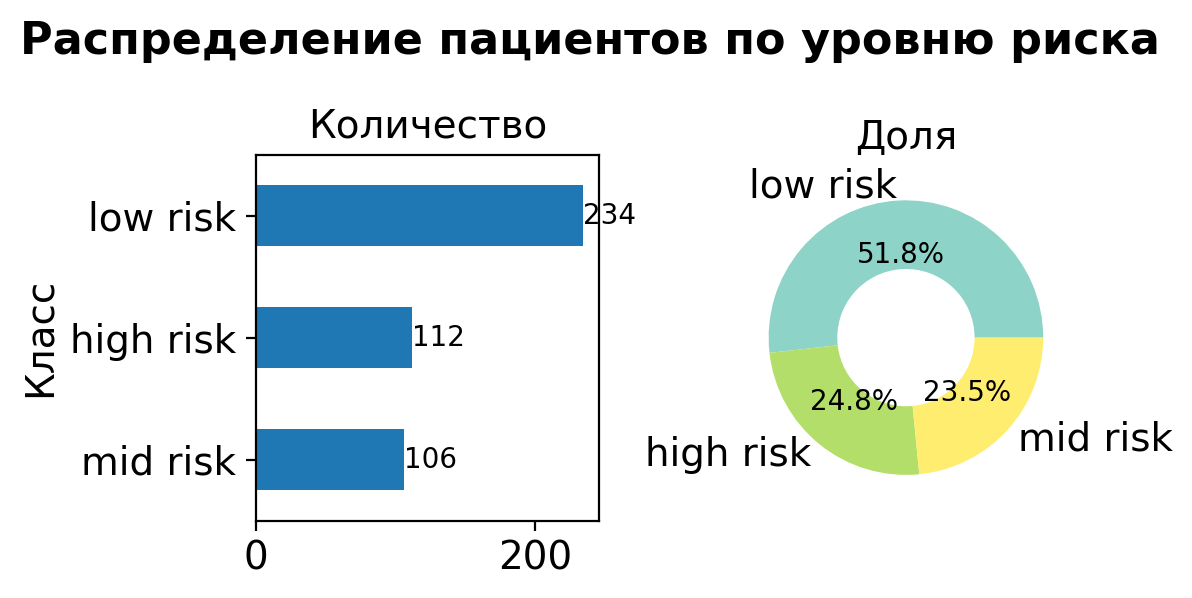

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
fig.suptitle('Распределение пациентов по уровню риска')

# построение графика
data['risk_level'] \
    .value_counts(ascending=True) \
        .to_frame() \
        .plot(y='count', kind='barh',
              legend=False, ax=ax1, figsize=(6, 3))

ax1.set_title('Количество')
ax1.set_ylabel('Класс')
ax1.set_xlabel('')

# добавление меток для каждого столбца
for index, value in enumerate(data['risk_level'].value_counts(ascending=True)):
    ax1.text(value, index, str(value), ha='left', va='center')

data['risk_level'] \
        .value_counts() \
        .to_frame() \
        .plot(y='count', kind='pie', autopct='%1.1f%%', legend=False, ylabel='',
              cmap='Set3', wedgeprops=dict(width=0.5), ax=ax2)
ax2.set_title('Доля')

plt.tight_layout()
plt.show()

В данных присутствует дисбаланс классов: данных по пациентам с низким уровнем риска в 2 раза больше (51.8% всех данных или 234 человека), чем пациентов со средним и высоким уровнем. Пациентов с высоким риском незначительно больше (на 1.3% или 6 человек), чем пациентов со средним уровнем риска.

Необходимо учесть этот дисбаланс при разбиении на выборки.
Для оценки качества модели будем использовать метрику ROC-AUC, которая нечувствительна к дисбалансу классов.

In [ ]:
low_risk = data.query('risk_level == "low risk"')
mid_risk = data.query('risk_level == "mid risk"')
high_risk = data.query('risk_level == "high risk"')

def build_hist_cont_feature(feature, feature_name, b):
    # входные данные:
    # feature - название столбца с количественным признаком,
    # feature_name - название признака
    # b - количество бинов для гистограммы

    print(f'Статистика для пациента с низким уровнем риска\n\n {low_risk[feature].describe()}')
    print(f'Статистика для пациента со средним уровнем риска\n\n {mid_risk[feature].describe()}')
    print(f'Статистика для пациента с высоким уровнем риска\n\n {high_risk[feature].describe()}')

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 8))
    plt.suptitle(feature_name+' в зависимости от уровня риска')

    axes[0].hist(low_risk[feature], histtype='step', bins=b, linewidth=5, alpha=0.7, label='Низкий уровень риска', density=True)
    axes[0].hist(mid_risk[feature], histtype='step', bins=b, linewidth=5, alpha=0.7, label='Средний уровень риска', density=True)
    axes[0].hist(high_risk[feature], histtype='step', bins=b, linewidth=5, alpha=0.7, label='Высокий уровень риска', density=True)
    axes[0].set_title('Распределение признака в зависимости от уровня риска')
    axes[0].set_ylabel('Плотность')
    axes[0].legend()

    axes[1].boxplot(low_risk[feature], positions=[1], widths=0.6, vert=False)
    axes[1].boxplot(mid_risk[feature], positions=[2], widths=0.6, vert=False)
    axes[1].boxplot(high_risk[feature], positions=[3], widths=0.6, vert=False)
    axes[1].set_title('Разброс значений признака')
    axes[1].set_yticklabels(['Низкий', 'Средний', 'Высокий'])
    axes[1].set_xlabel(feature_name)
    plt.show()

Статистика для пациента с низким уровнем риска

 count    234.000000
mean      27.320513
std       13.882549
min       10.000000
25%       18.000000
50%       22.000000
75%       33.500000
max       70.000000
Name: age, dtype: float64
Статистика для пациента со средним уровнем риска

 count    106.000000
mean      28.537736
std       12.716075
min       10.000000
25%       19.000000
50%       25.500000
75%       32.000000
max       60.000000
Name: age, dtype: float64
Статистика для пациента с высоким уровнем риска

 count    112.000000
mean      33.732143
std       13.565312
min       12.000000
25%       25.000000
50%       33.500000
75%       42.000000
max       65.000000
Name: age, dtype: float64


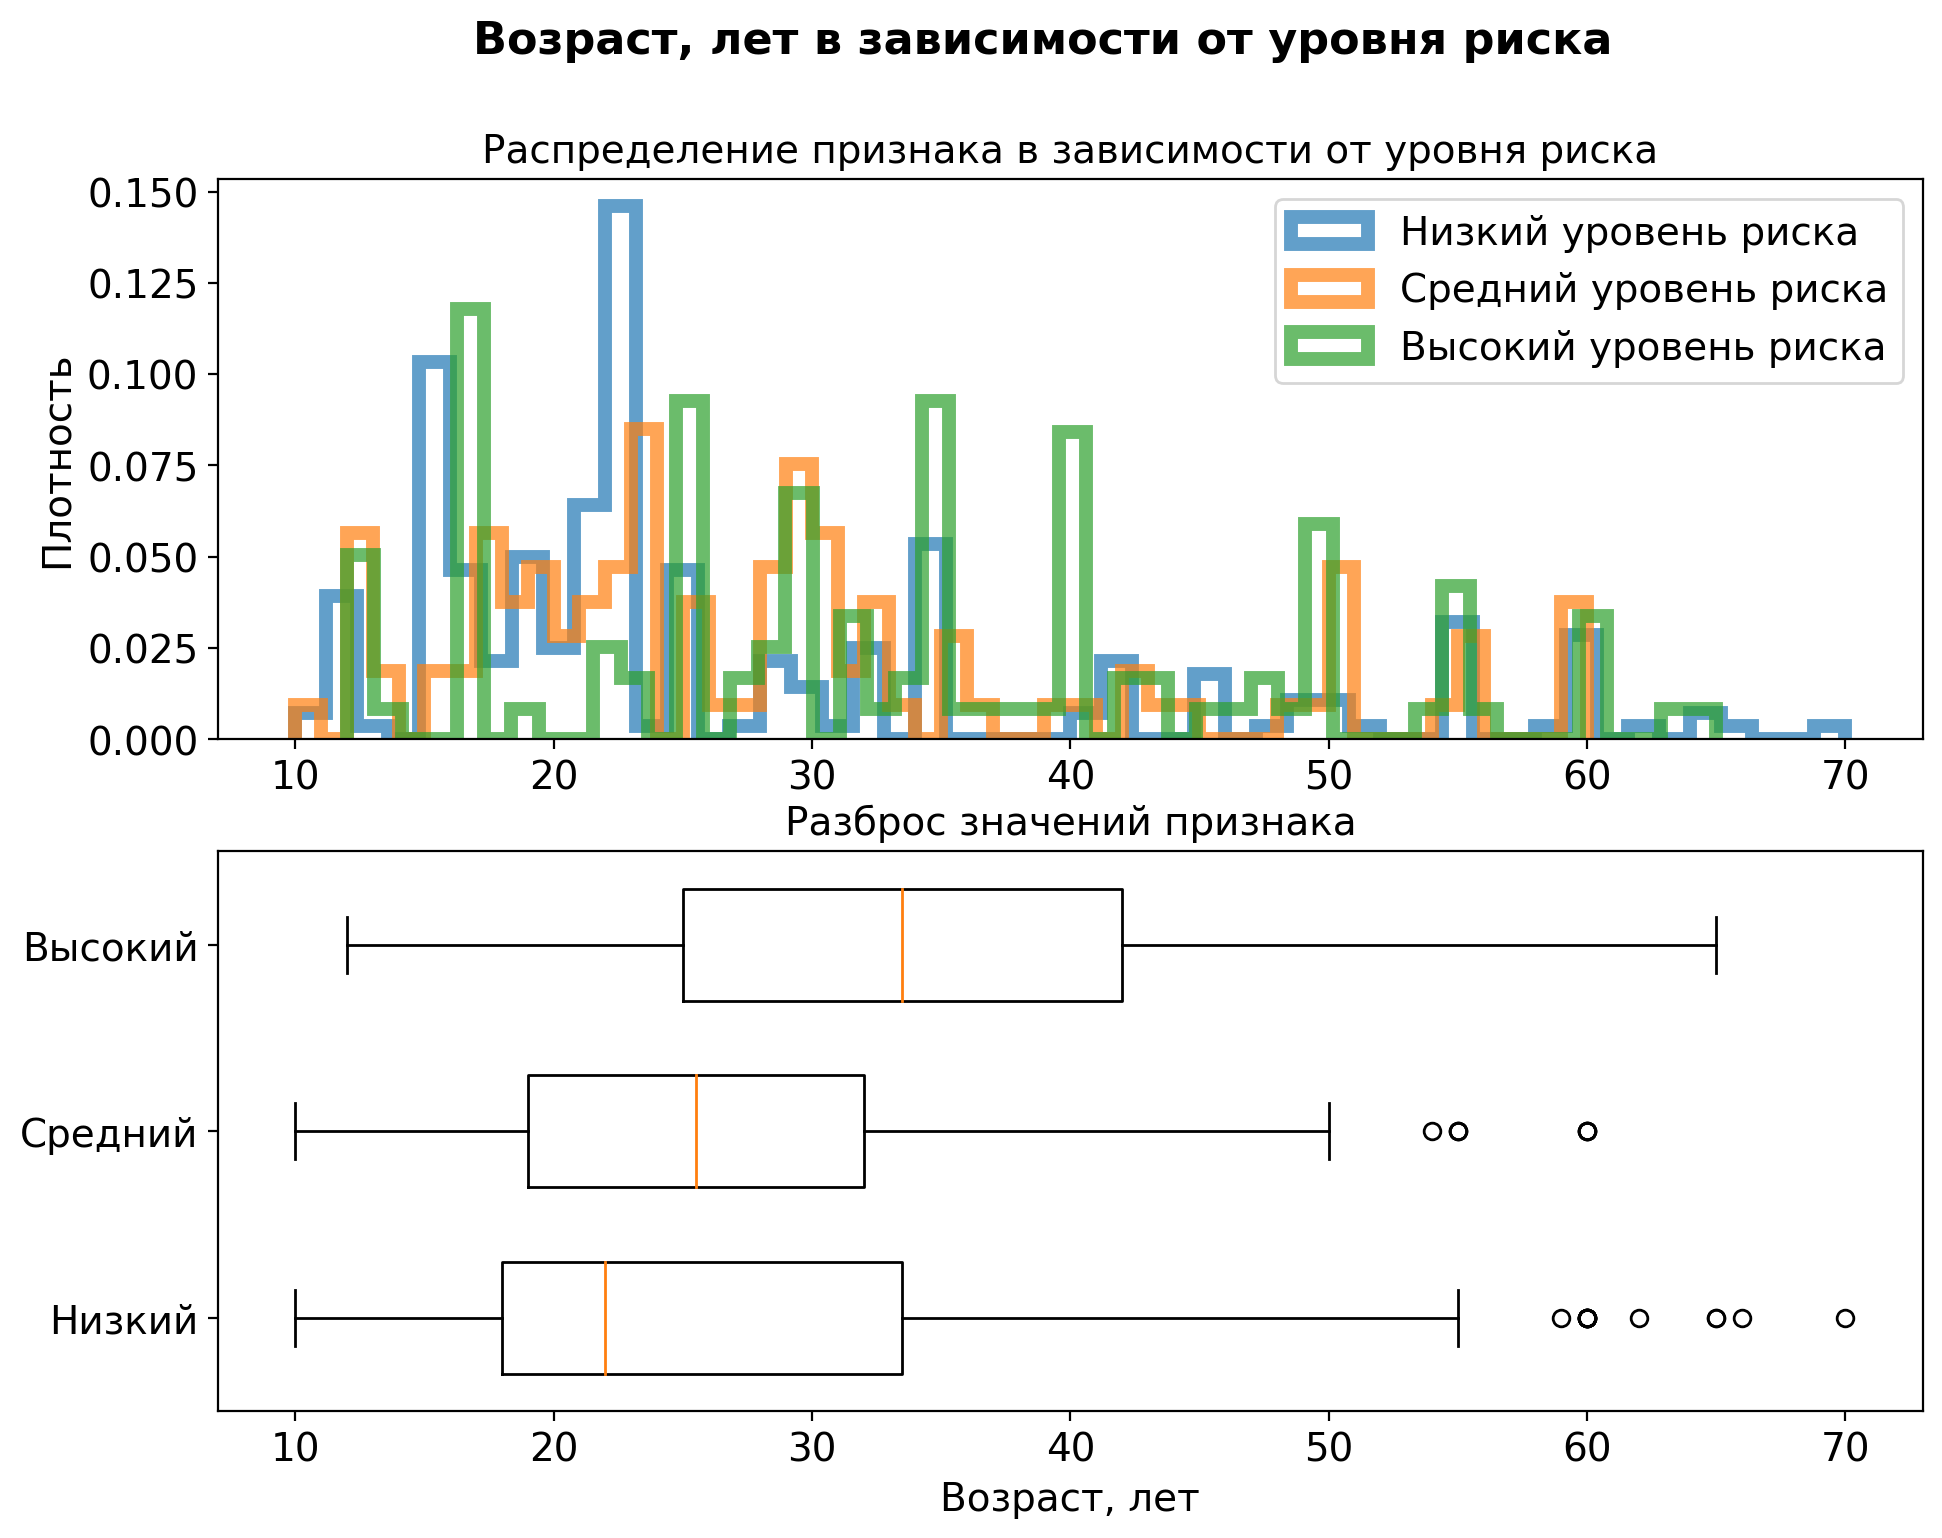

In [ ]:
# вызов функции для вывода описательной статистики и построения гистограммы и боксплота
build_hist_cont_feature('age', 'Возраст, лет', 50)

По диаграмме размаха отчетливо прослеживается прямая связь между возрастом и уровнем риска. Медианное значение возраста показывает, что чем больше возраст женщины, тем выше риск: медианный возраст женщин с низким уровнем риска равно 22 года, женщин со средним уровнем риска - 25.5 лет, а женщин с высоким риском - 32 года. Также в данных присутствуют значения, выбивающиеся за пределы верхнего "уса". Судя по данным из интернета самой возрастной женщине, родившей детей, было 76 года, поэтому оставим эти выбивающиеся значения в датасете.

Статистика для пациента с низким уровнем риска

 count    234.000000
mean     105.435897
std       15.505438
min       70.000000
25%       90.000000
50%      100.000000
75%      120.000000
max      129.000000
Name: systolic_bp, dtype: float64
Статистика для пациента со средним уровнем риска

 count    106.000000
mean     112.405660
std       15.059108
min       70.000000
25%      100.000000
50%      120.000000
75%      120.000000
max      140.000000
Name: systolic_bp, dtype: float64
Статистика для пациента с высоким уровнем риска

 count    112.000000
mean     119.491071
std       20.965435
min       83.000000
25%       98.750000
50%      120.000000
75%      140.000000
max      160.000000
Name: systolic_bp, dtype: float64


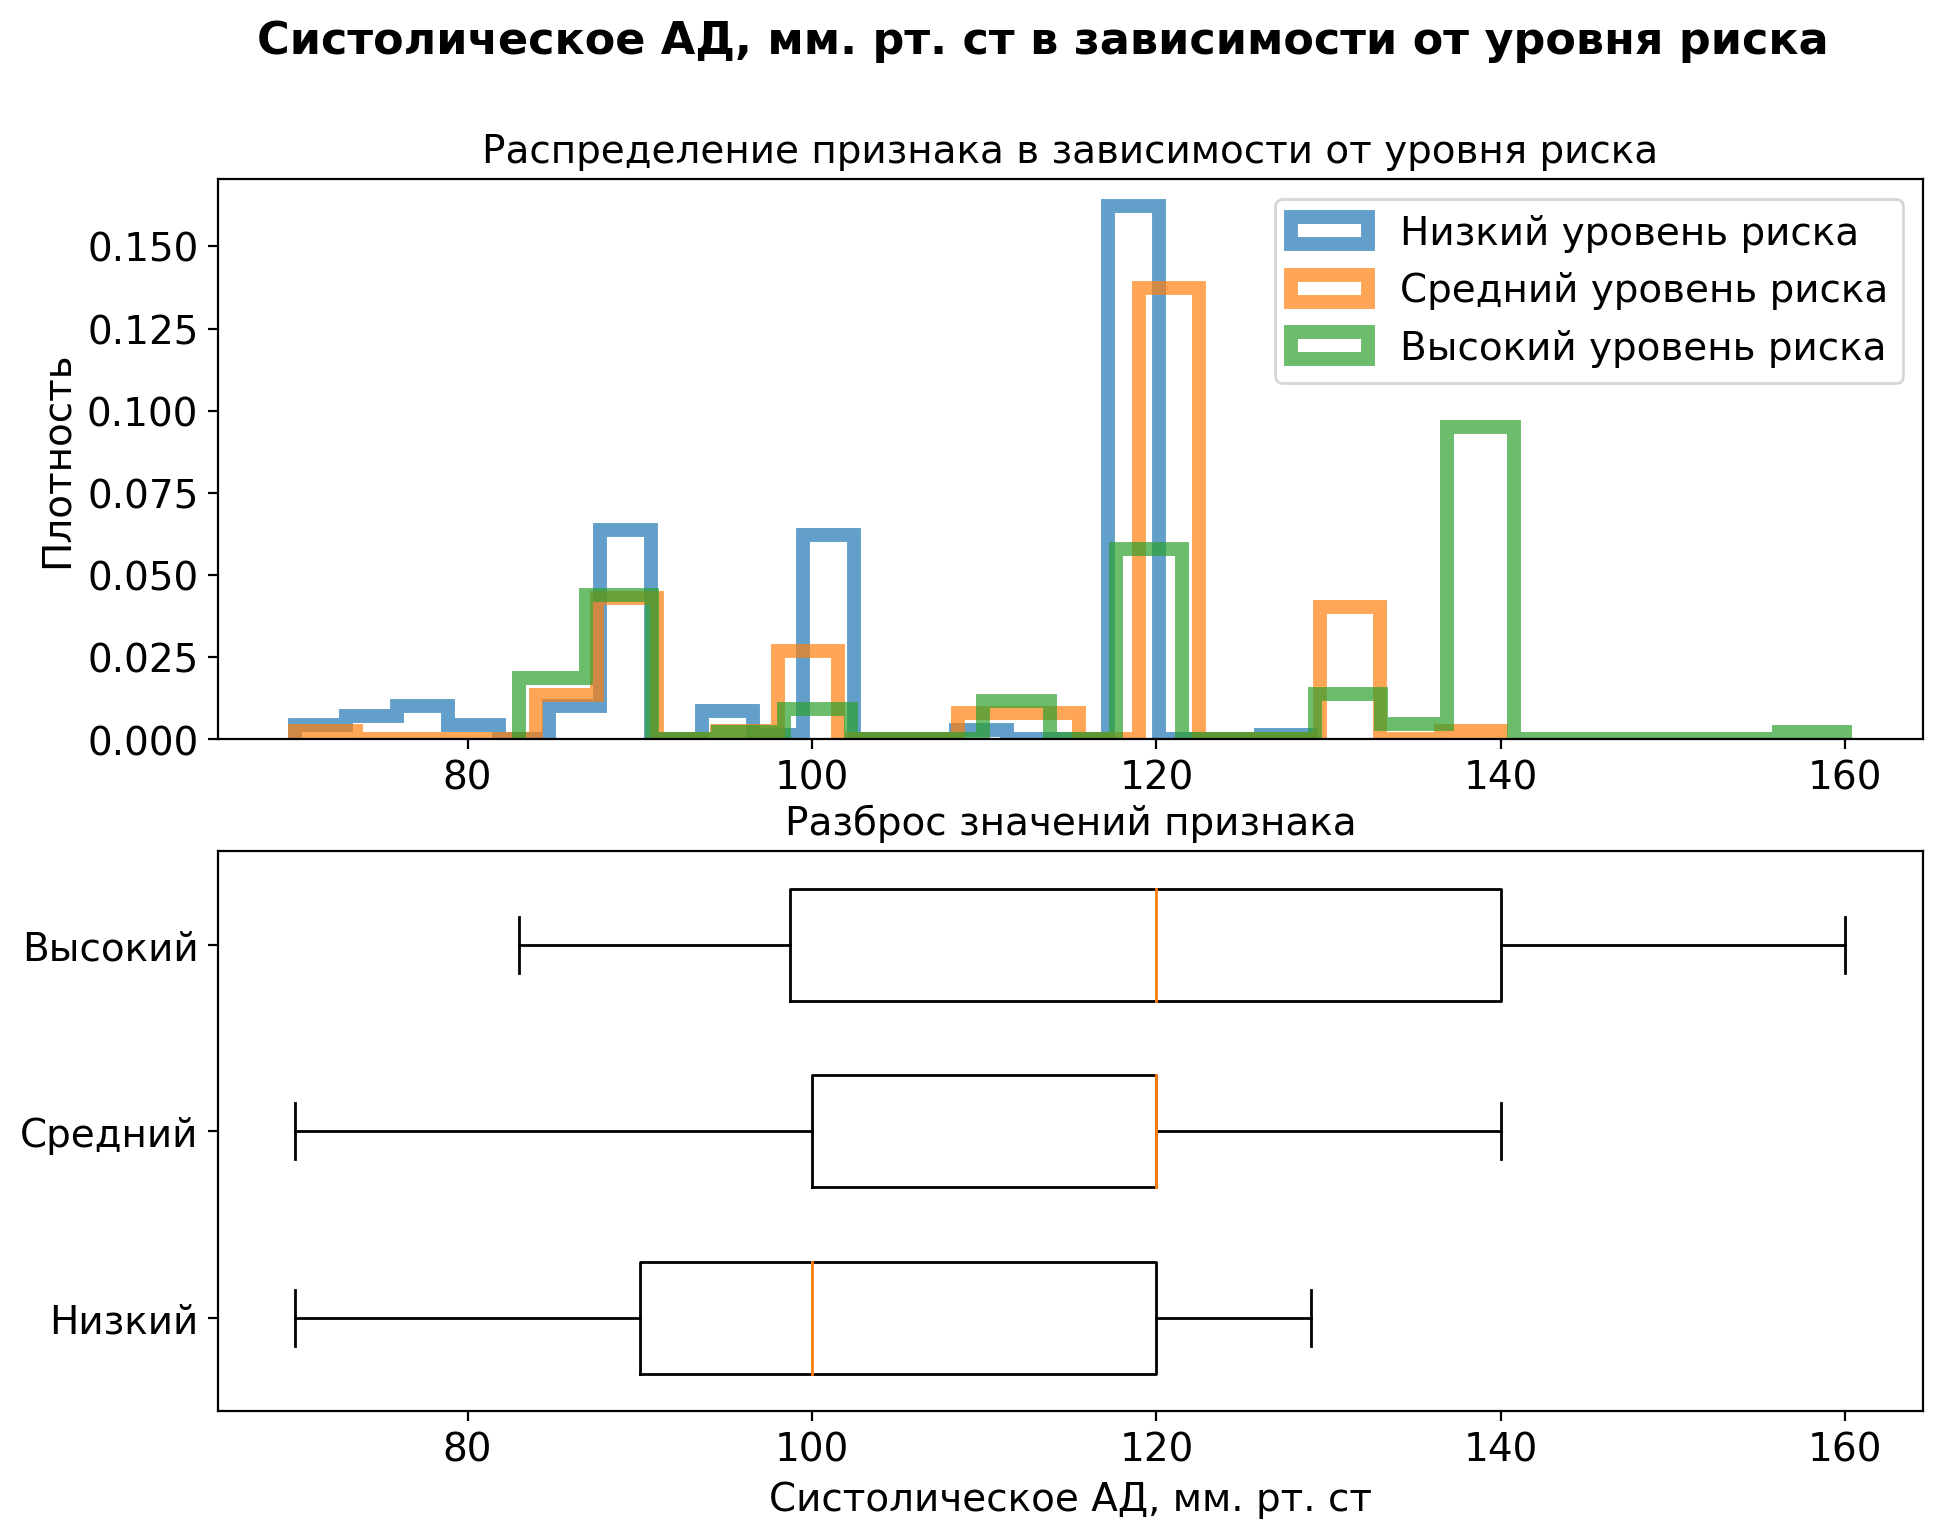

In [ ]:
# вызов функции для вывода описательной статистики и построения гистограммы и боксплота
build_hist_cont_feature('systolic_bp', 'Систолическое АД, мм. рт. ст', 20)

In [ ]:
# расчет моды
for title, df in zip(('Низкий риск', 'Средний риск', 'Высокий риск'), (low_risk, mid_risk, high_risk)):
  print(f'Мода для {title}: {st.mode(df["systolic_bp"])}')

Мода для Низкий риск: 120
Мода для Средний риск: 120
Мода для Высокий риск: 140


По гистограмме видно, что распределение похоже на распределение дискретного признака и что лучше ориентироваться на моду, чем на медиану. Данный признак показывает, что уровень давления одинаков и равен нормальному (120 мм.рт.ст.) при низком и среднем риске, а также является хорошим диагностическим признаком высокого давления.

Статистика для пациента с низким уровнем риска

 count    234.000000
mean      72.730769
std       13.081789
min       49.000000
25%       60.000000
50%       75.000000
75%       80.000000
max      100.000000
Name: diastolic_bp, dtype: float64
Статистика для пациента со средним уровнем риска

 count    106.000000
mean      74.886792
std       12.166559
min       50.000000
25%       65.000000
50%       77.500000
75%       85.000000
max      100.000000
Name: diastolic_bp, dtype: float64
Статистика для пациента с высоким уровнем риска

 count    112.000000
mean      81.535714
std       14.703023
min       60.000000
25%       68.000000
50%       80.000000
75%       95.000000
max      100.000000
Name: diastolic_bp, dtype: float64


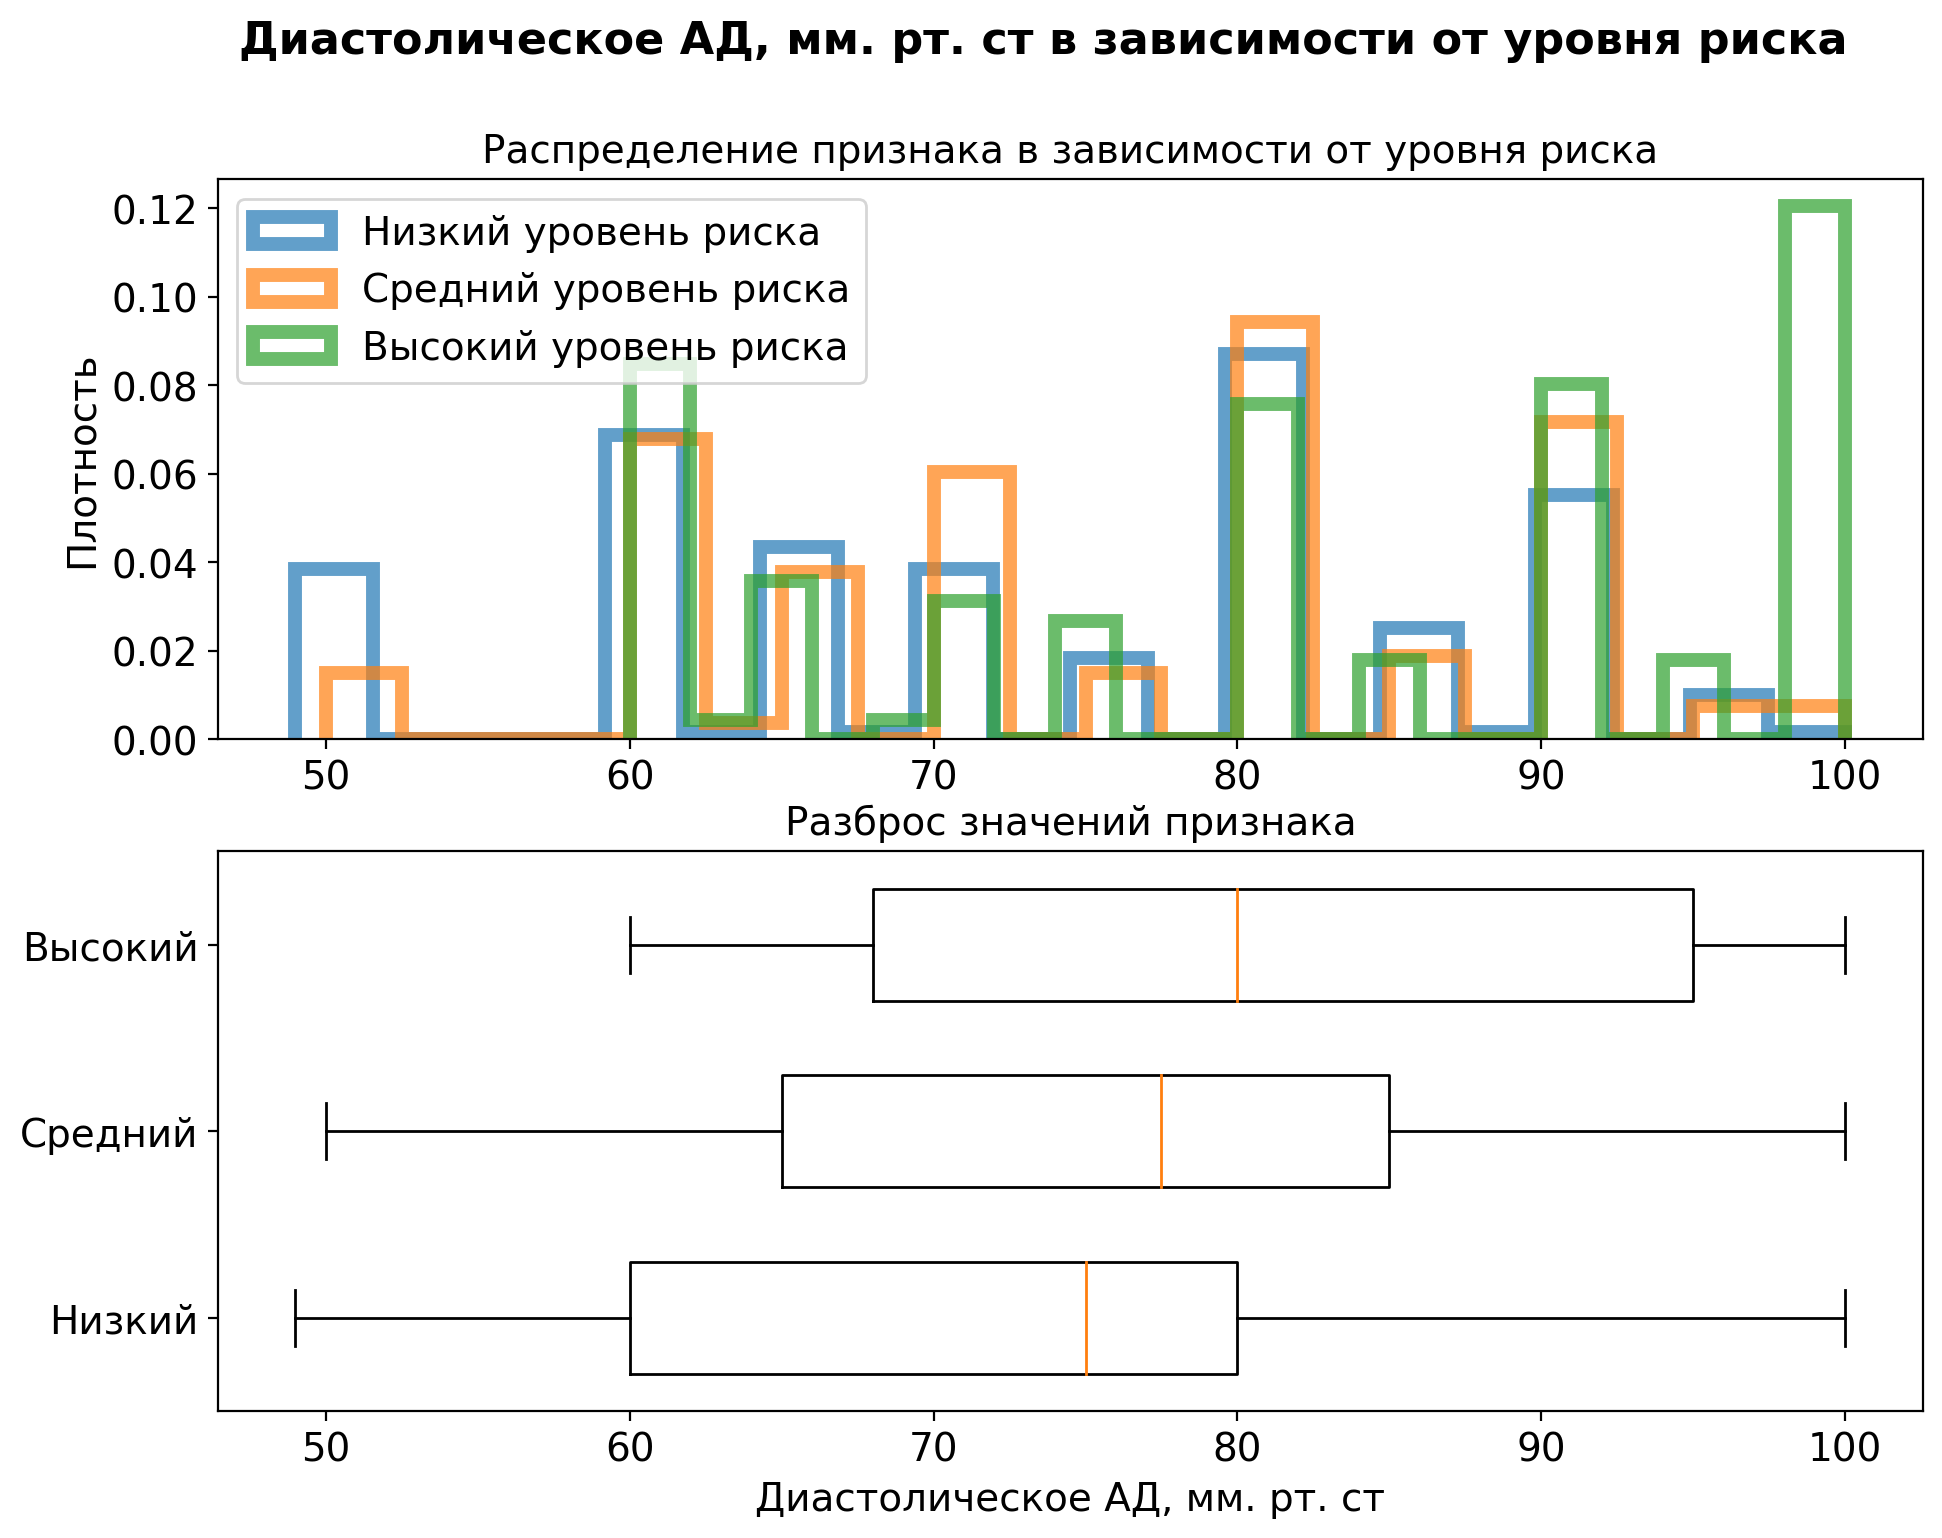

In [ ]:
# вызов функции для вывода описательной статистики и построения гистограммы и боксплота
build_hist_cont_feature('diastolic_bp', 'Диастолическое АД, мм. рт. ст', 20)

In [ ]:
# расчет моды
for title, df in zip(('Низкий риск', 'Средний риск', 'Высокий риск'), (low_risk, mid_risk, high_risk)):
  print(f'Мода для {title}: {st.mode(df["diastolic_bp"])}')

Мода для Низкий риск: 80
Мода для Средний риск: 80
Мода для Высокий риск: 100


Диастолическое давление также позволяет выявить пациентов с высоким уровнем риска, который ассоциирован с высоким АД равным 100 мм.рт.ст.

Статистика для пациента с низким уровнем риска

 count    234.000000
mean       7.201838
std        0.568363
min        6.000000
25%        6.900000
50%        7.200000
75%        7.500000
max       11.000000
Name: bs, dtype: float64
Статистика для пациента со средним уровнем риска

 count    106.000000
mean       7.893585
std        2.383055
min        6.000000
25%        6.800000
50%        7.000000
75%        7.800000
max       18.000000
Name: bs, dtype: float64
Статистика для пациента с высоким уровнем риска

 count    112.000000
mean      11.165357
std        3.936601
min        6.100000
25%        7.650000
50%       11.000000
75%       15.000000
max       19.000000
Name: bs, dtype: float64


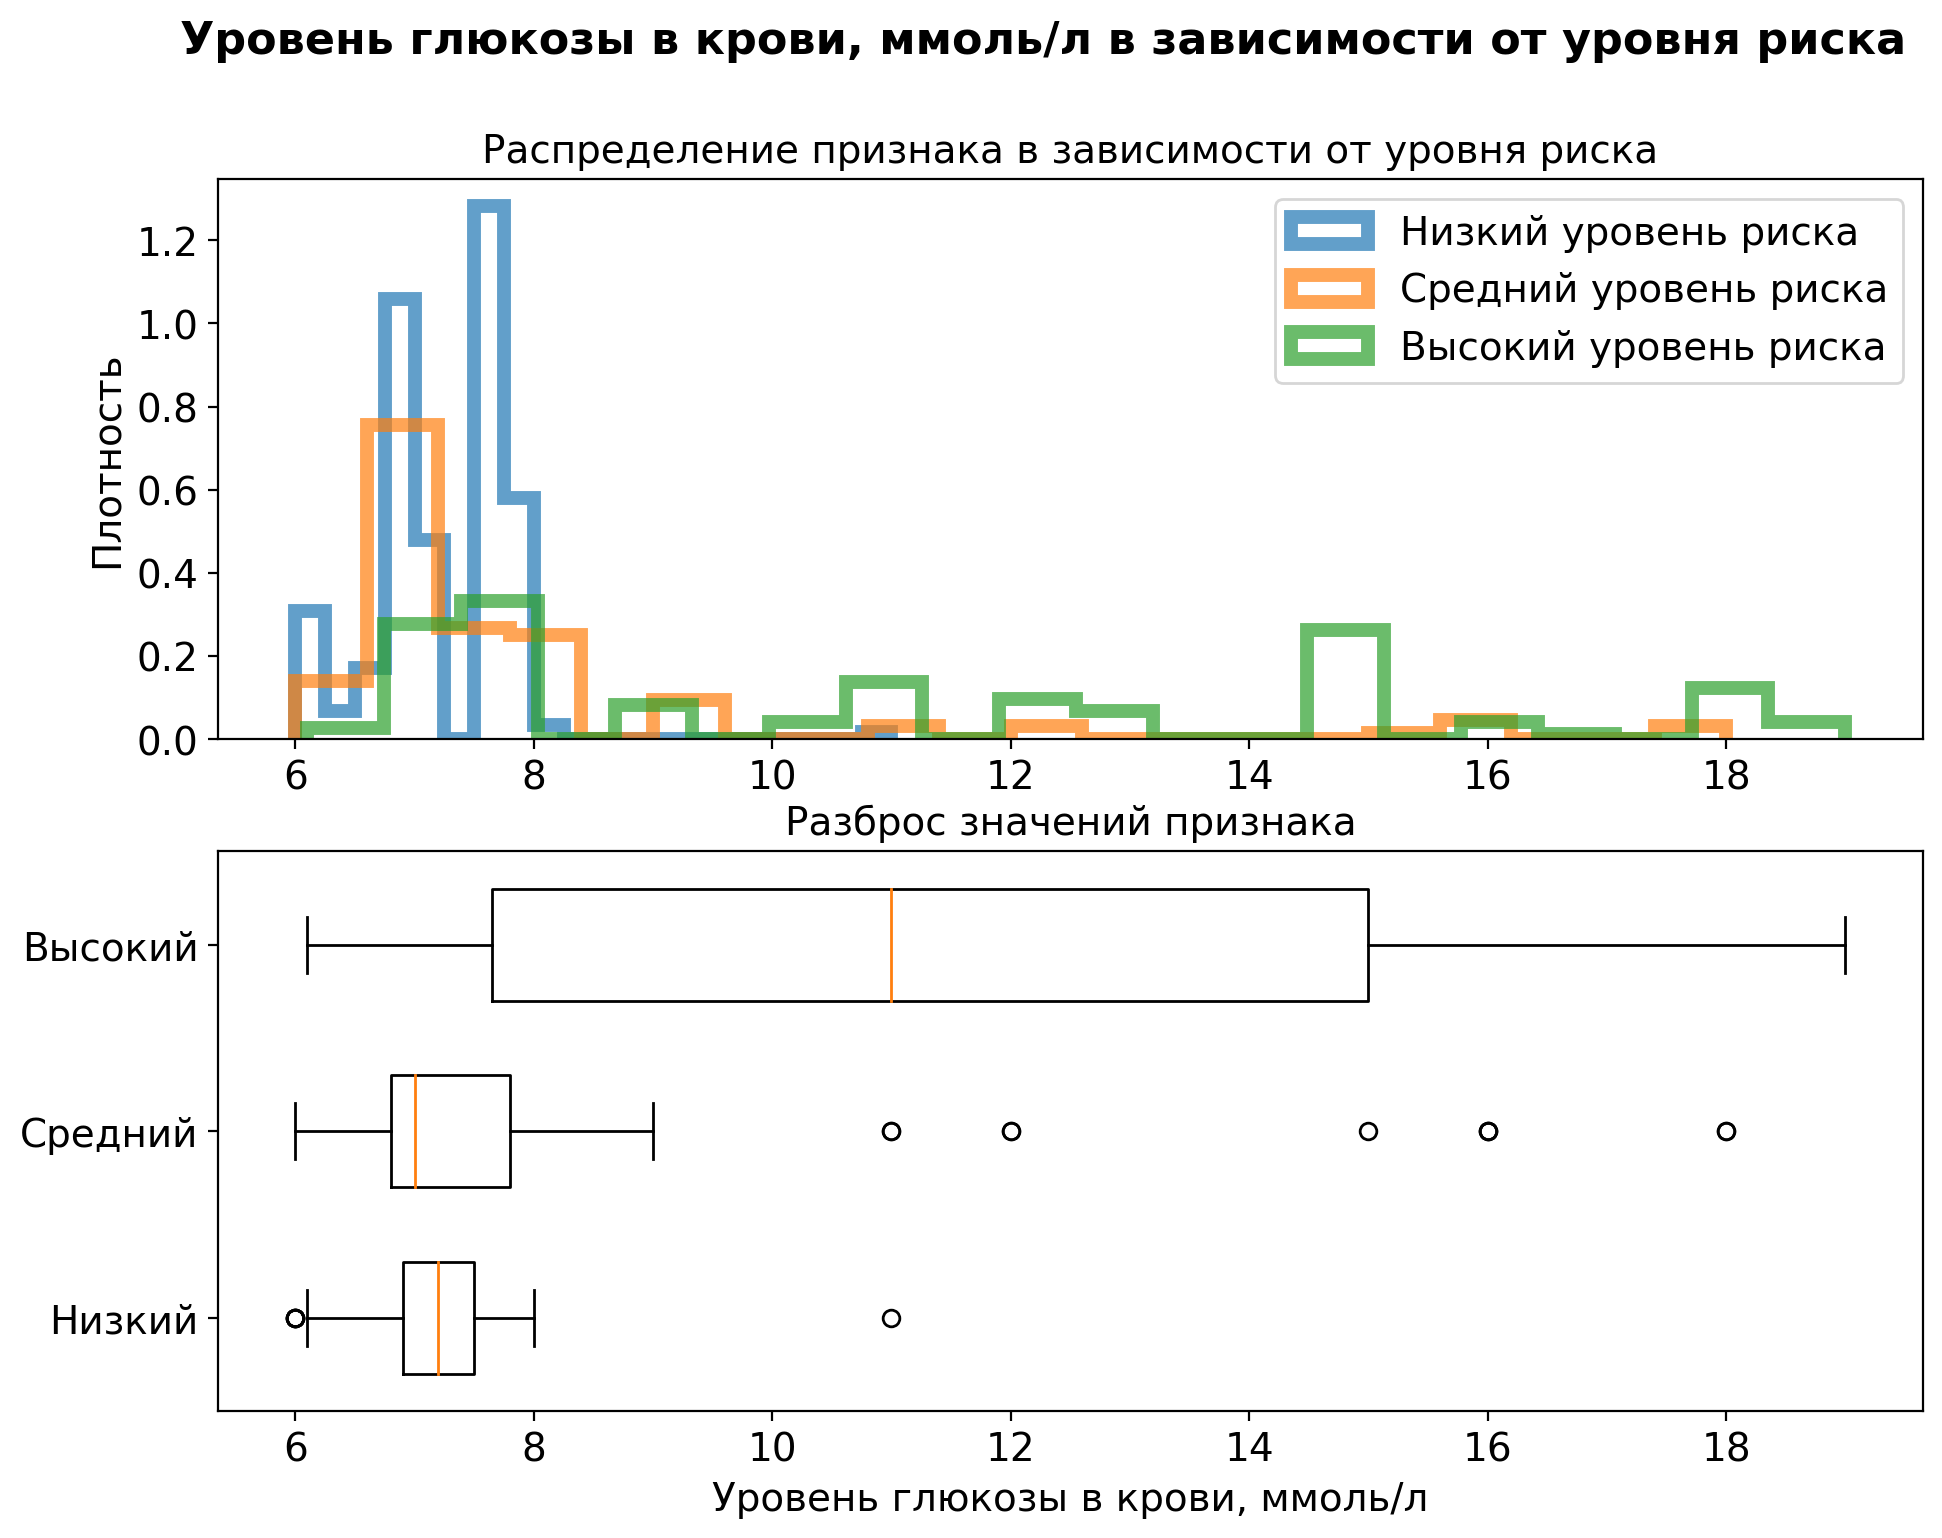

In [ ]:
# вызов функции для вывода описательной статистики и построения гистограммы и боксплота
build_hist_cont_feature('bs', 'Уровень глюкозы в крови, ммоль/л', 20)

In [ ]:
# расчет моды
for title, df in zip(('Низкий риск', 'Средний риск', 'Высокий риск'), (low_risk, mid_risk, high_risk)):
  print(f'Мода для {title}: {st.mode(df["bs"])}')

Мода для Низкий риск: 7.5
Мода для Средний риск: 6.9
Мода для Высокий риск: 15.0


Распределение пациентов с низким уровнем риска имеет наименьшую дисперсию: стандартное отклонение равно 0.57 ммоль/л. Наибольшим разбросом характеризуются пациенты с высоким риском: стандартное отклонение равно 3.94 ммоль/л. Уровень глюкозы также является хорошим диагностическим признаком для выявления высокорисковых пациентов. Уровень глюкозы больше 9 ммоль/л свидетельствует о высоком риске.

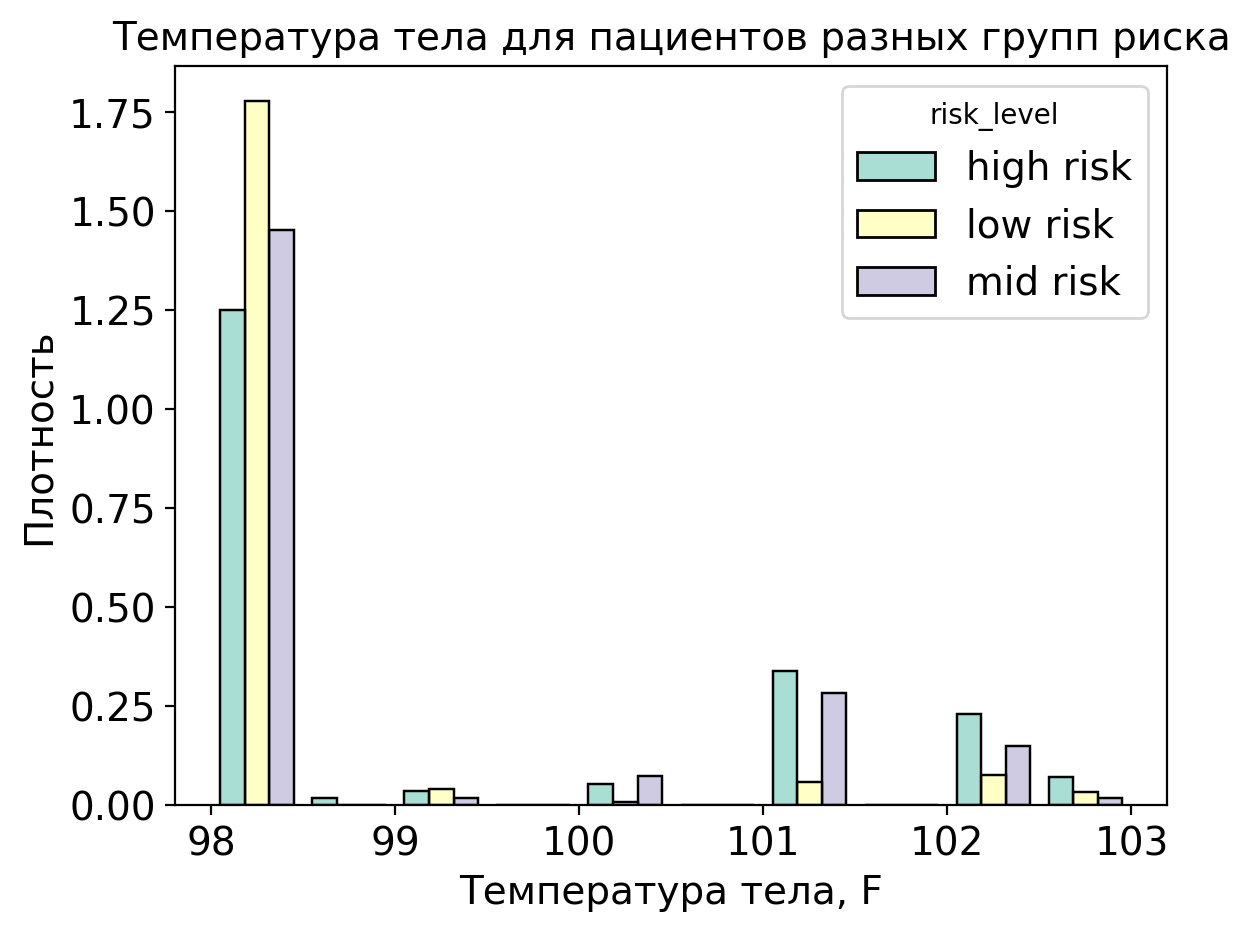

In [ ]:
# построение гистограммы для признака `body_temp`
sns.histplot(data, x='body_temp', hue='risk_level', palette='Set3', multiple="dodge",
                  stat = 'density', shrink = 0.8, common_norm=False)
plt.title('Температура тела для пациентов разных групп риска')
plt.xlabel('Температура тела, F')
plt.ylabel('Плотность')
plt.show()

Признак `body_temp` скорее дискретный, чем непрерывный, поэтому для него построим только гистограмму. Большинство значений для всех групп риска группируются около нормальной температуры равной 98F. Также присутствуют беременные всех трех групп риска с температурой тела до 103F (39.4 по Цельсию). Таким образом, данный признак не позволяет уверенно разграничить пациентов по группам риска.

Статистика для пациента с низким уровнем риска

 count    234.000000
mean      73.029915
std        7.010351
min       60.000000
25%       70.000000
50%       70.000000
75%       77.000000
max       88.000000
Name: heart_rate, dtype: float64
Статистика для пациента со средним уровнем риска

 count    106.000000
mean      73.896226
std        7.000584
min       60.000000
25%       70.000000
50%       76.000000
75%       78.000000
max       88.000000
Name: heart_rate, dtype: float64
Статистика для пациента с высоким уровнем риска

 count    112.000000
mean      76.482143
std        8.504352
min       60.000000
25%       70.000000
50%       77.000000
75%       80.000000
max       90.000000
Name: heart_rate, dtype: float64


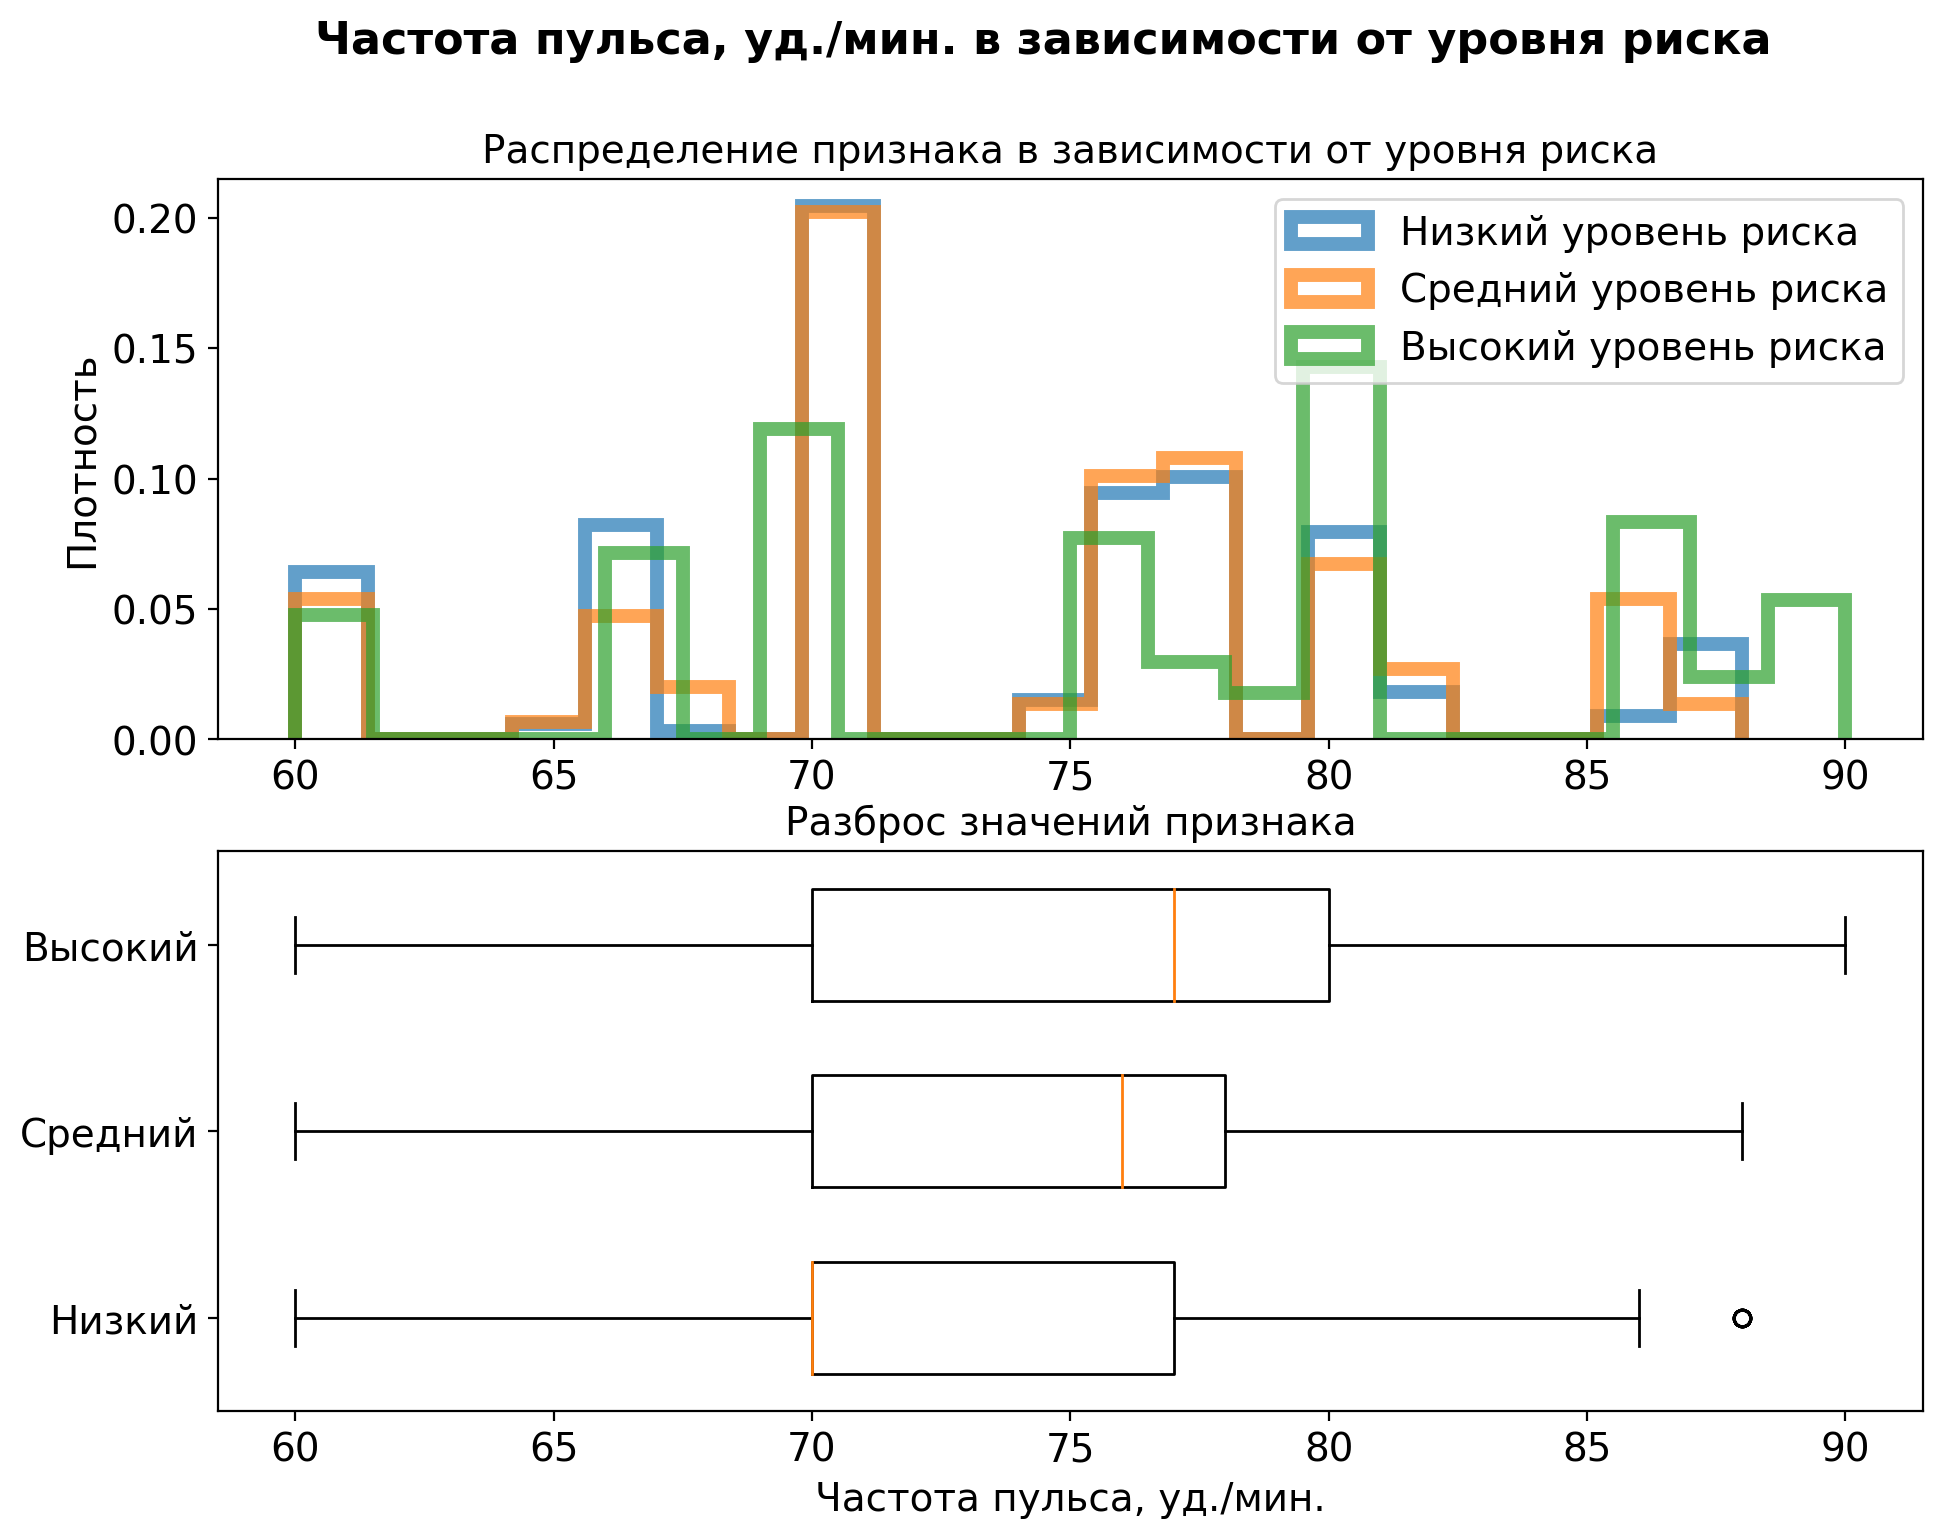

In [ ]:
# вызов функции для вывода описательной статистики и построения гистограммы и боксплота
build_hist_cont_feature('heart_rate', 'Частота пульса, уд./мин.', 20)

In [ ]:
# расчет моды
for title, df in zip(('Низкий риск', 'Средний риск', 'Высокий риск'), (low_risk, mid_risk, high_risk)):
  print(f'Мода для {title}: {st.mode(df["heart_rate"])}')

Мода для Низкий риск: 70
Мода для Средний риск: 70
Мода для Высокий риск: 80


Значение частоты пульса не позволяет разграничить пациентов со средним и низким уровнем риска. Мода для них равна 70 уд./мин. Высокий пульс (мода 80 уд./мин.), как правило, свидетельствует о высоком риске.

<font size="4"><b>Выводы по исследовательскому анализу данных</b></font>
- В данных присутствует дисбаланс классов: данных по пациентам с низким уровнем риска в 2 раза больше (51.8% всех данных или 234 человека), чем пациентов со средним и высоким уровнем.
- Пациентов с высоким риском незначительно больше (на 1.3% или 6 человек), чем пациентов со средним уровнем риска.
- Признаки, позволяющие хорошо разграничить пациентам по трём группам риска: `age`, `bs`.
- Признаки, позволяющие хорошо выявить пациентов с высоким уровнем риска, но плохо разграничивающим низкий и средний уровень: `systolic_bp`, `diastolic_bp`, `heart_rate`.
- Признак, плохо разграничивающий пациентов по группам риска: `body_temp`.

## Корреляционный анализ

Рассчитаем коэффициенты корреляции между признаками разных типов данных. Для этого используем библиотеку phik.

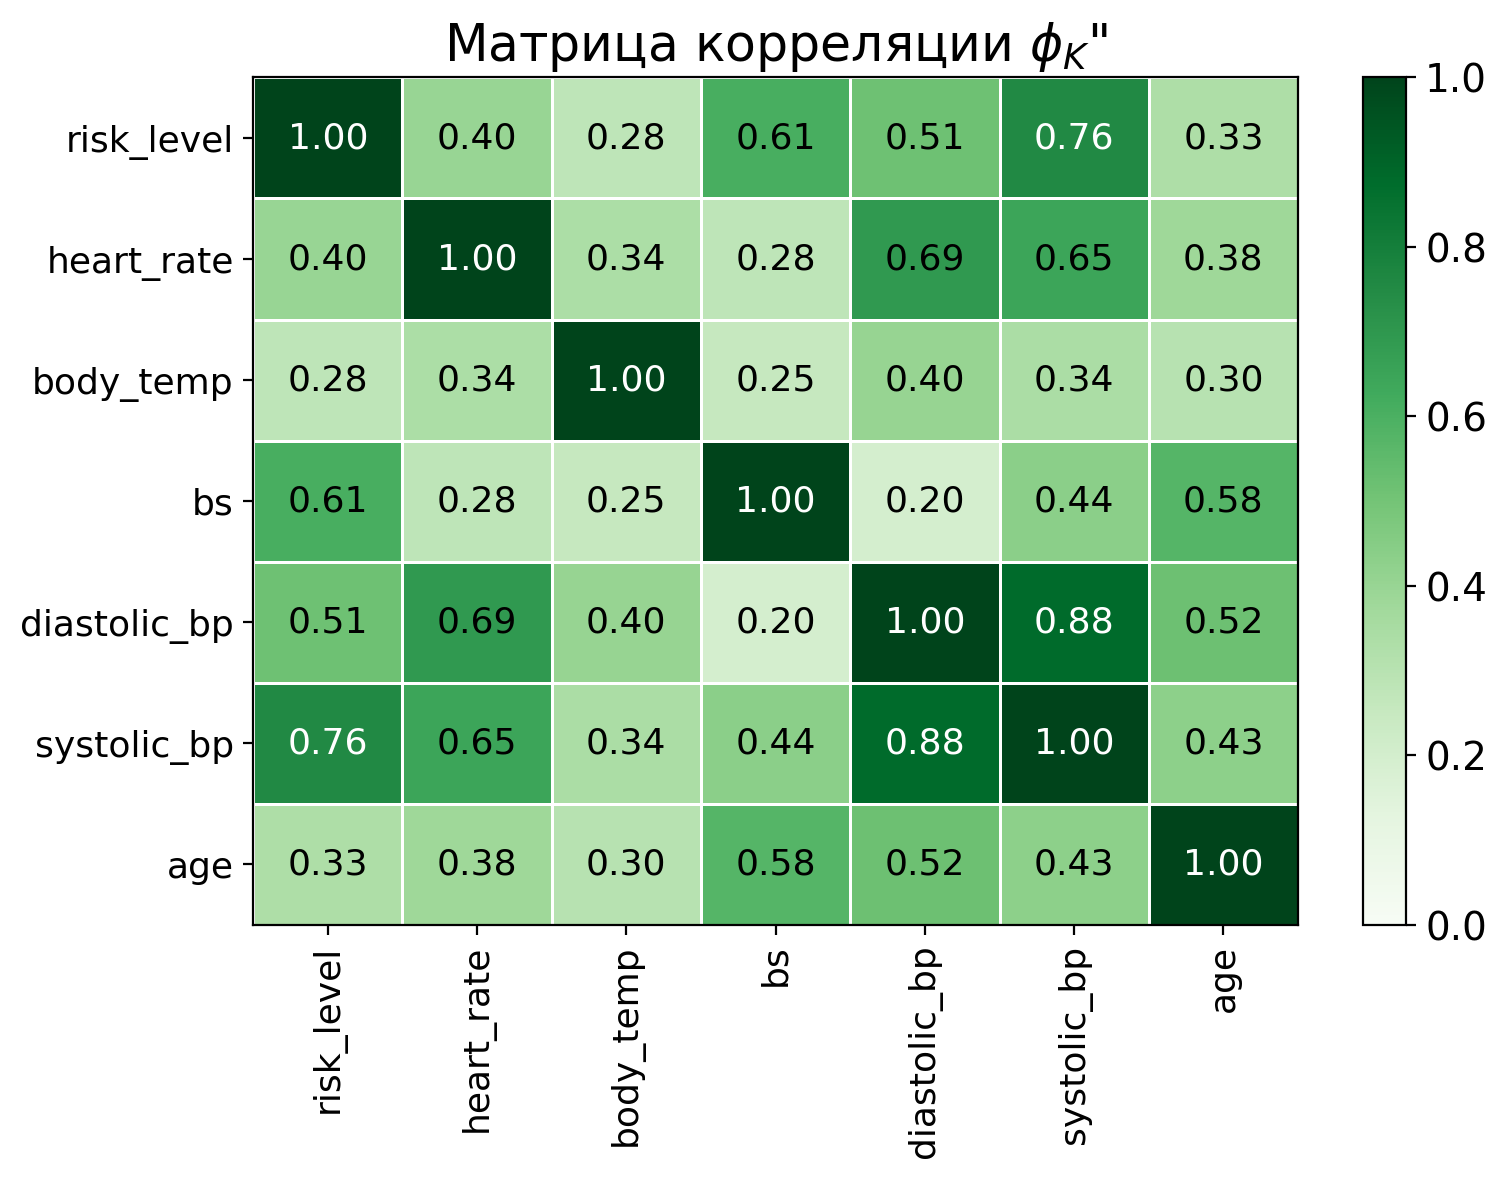

In [ ]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['age', 'systolic_bp', 'diastolic_bp', 'bs', 'body_temp', 'heart_rate']

# считаем коэффициенты корреляции
phik_overview= phik_matrix(data, interval_cols=interval_cols)

# строим матрицу корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции $\phi_K$"',
    fontsize_factor=1.3,
    figsize=(8, 6)
)
plt.show()


Мультиколлинеарность не наблюдается.

Наибольшая взаимосвязь целевого признака с систолическим давлением равная 0.76.

## Обучение моделей

Таким образом в обучении будем использовать 6 входных признаков: 'age', 'systolic_bp', 'diastolic_bp', 'bs', 'body_temp', 'heart_rate'. Они все количественные. Категориальных нет.

Данных не так много, поэтому под обучение используем 90% всех данных.

При разбиении на выборки сделаем стратификацию.

Оценивать качество будем по метрике ROC-AUC, т.к. она не чувствительна к дисбалансу классов.

In [ ]:
# замена значений целевого признака со строкового типа на числовой
data['risk_level'] = data['risk_level'].map({'low risk': 0, 'mid risk': 1,
                               'high risk': 2})

In [ ]:
# записываем входные данные в переменную Х, целевой признак в переменную у
X = data.drop(['risk_level'], axis=1)
y = data['risk_level']

# делим выборку на тренировочную и тестовую со статификацией по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = y)

print(f"Размер обучающей выборки: {X_train.shape}, тестовой выборки: {X_test.shape}")

num_columns = ['age', 'systolic_bp', 'diastolic_bp', 'bs', 'body_temp', 'heart_rate']

Размер обучающей выборки: (406, 6), тестовой выборки: (46, 6)


In [ ]:
# создание пустого списка для добавления лучших метрик по всем лучшим моделям
rocauc_cv = []

def prep_model_pipe(model, params):
    '''
    Функция, которая подготавливает признаки, производит подбор гиперпараметров и
    возвращает лучшую модель
    '''

    data_preprocessor = ColumnTransformer(
    [
      ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

    # финальный пайплайн
    pipeline = Pipeline([
        ('preprocessor', data_preprocessor),
        ('clf', model),
    ])

    gs = GridSearchCV(
        pipeline,
        param_grid=params,
        cv=3,
        scoring='roc_auc_ovo_weighted',
        n_jobs=-1, verbose=0
    )

    # запуск поискa  лучших гиперпараметров
    gs.fit(X_train, y_train)

    print('Параметры лучшей модели:\n\n', gs.best_estimator_)

    roc_auc_ovo = gs.best_score_

    rocauc_cv.append(roc_auc_ovo)
    print(f'Лучшая метрика ROC-AUC-ovo на кросс-валидации: {round(roc_auc_ovo, 3)}')

    return gs.best_estimator_

### Модель LogisticRegression

In [ ]:
# словарь с параметрами для LogisticRegression
lr_params = {'clf__C': [0.01, 1, 10],
             'clf__penalty': ['l1', 'l2']
            }

# инициализируем модель LogisticRegression
model_lr = LogisticRegression(random_state=RANDOM_STATE,
                              solver='liblinear',
                              max_iter=200)

# вызов функции с расчетом матрицы признаков и подбором гиперпараметров для LogisticRegression
model_lr = prep_model_pipe(model_lr, lr_params)

Параметры лучшей модели:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'systolic_bp',
                                                   'diastolic_bp', 'bs',
                                                   'body_temp',
                                                   'heart_rate'])])),
                ('clf',
                 LogisticRegression(C=1, max_iter=200, random_state=10,
                                    solver='liblinear'))])
Лучшая метрика ROC-AUC-ovo на кросс-валидации: 0.75


### Модель KNeighborsClassifier

In [ ]:
# словарь с параметрами для KNeighborsClassifier
knn_params = {'clf__n_neighbors': range(2, 20, 2)
            }

# инициализируем модель KNeighborsClassifier
model_knn = KNeighborsClassifier(n_jobs=-1)

# вызов функции с расчетом матрицы признаков и подбором гиперпараметров для KNeighborsClassifier
model_knn = prep_model_pipe(model_knn, knn_params)

Параметры лучшей модели:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'systolic_bp',
                                                   'diastolic_bp', 'bs',
                                                   'body_temp',
                                                   'heart_rate'])])),
                ('clf', KNeighborsClassifier(n_jobs=-1, n_neighbors=18))])
Лучшая метрика ROC-AUC-ovo на кросс-валидации: 0.733


### Модель RandomForestClassifier

In [ ]:
# передадим словарь с параметрами для RandomForestClassifier
params_rfc = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [10, 20],
    'clf__min_samples_split': [2, 5]
}

# инициализируем модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=RANDOM_STATE)

# вызов функции с подготовкой признаков и подбором гиперпараметров для RandomForest
model_rfc = prep_model_pipe(rfc, params_rfc)

Параметры лучшей модели:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'systolic_bp',
                                                   'diastolic_bp', 'bs',
                                                   'body_temp',
                                                   'heart_rate'])])),
                ('clf',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        random_state=10))])
Лучшая метрика ROC-AUC-ovo на кросс-валидации: 0.76


### Модель XGBClassifier

In [ ]:
# передадим словарь с параметрами для XGBClassifier
params_xgbst = {'clf__learning_rate': [0.05, 0.1],
              'clf__n_estimators': [100, 150],
              'clf__max_depth': [5, 10]
}

# инициализируем модель XGBClassifier
xgbst = XGBClassifier(random_state=RANDOM_STATE)

# вызов функции с расчетом матрицы признаков и подбором гиперпараметров для XGBClassifier
model_xgbst = prep_model_pipe(xgbst, params_xgbst)

Параметры лучшей модели:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'systolic_bp',
                                                   'diastolic_bp', 'bs',
                                                   'body_temp',
                                                   'heart_rate'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=N...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
     

## Тестирование

Соберем все метрики ROC-AUC, оцененные на кросс-валидации по всем моделям в датафрейм.

In [ ]:
result = pd.DataFrame(
    {
    "Модель": ['LogisticRegression', 'KNeighboursClassifier', 'RandomForestClassifier', 'XGBClassifier'],
    "ROC-AUC на cv": rocauc_cv
    }
)

result.sort_values(by='ROC-AUC на cv', ascending=False)

,Модель,ROC-AUC на cv
3,XGBClassifier,0.773432
2,RandomForestClassifier,0.759941
0,LogisticRegression,0.749728
1,KNeighboursClassifier,0.732995


На кросс-валидации лучшую метрику показала модель XGBClassifier. Сравним ее с константной моделью.

In [ ]:
# создание и обучение модели DummyClassifier
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict_proba(X_test)

# оценка качества dummy модели по метрике ROC-AUC
rocauc_dummy = roc_auc_score(y_test, dummy_model_preds, multi_class='ovo')
print(f'Метрика ROC-AUC на тестовой выборке дамми-модели: {round(rocauc_dummy, 3)}')

Метрика ROC-AUC на тестовой выборке дамми-модели: 0.5


Все метрики ROC-AUC, полученные ранее, оказались намного лучше метрики на дамми-модели. Таким образом, убедились, что обученная модель даёт прирост качества и проверим её качество на тестовых данных.

Рассчитаем метрику ROC-AUC на тестовых данных на модели XGBClassifier, а также выведем таблицу `classification_report` с расчетом метрик precision, recall и F1-мера.

In [ ]:
# рассчитаем прогноз и метрики на тестовых данных
y_test_pred = model_xgbst.predict(X_test)
y_pred = model_xgbst.predict_proba(X_test)
roc_auc_test = roc_auc_score(y_test, y_pred, multi_class='ovo')
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_test, 3)}')

report = classification_report(y_test, y_test_pred, target_names=['низкий', 'средний', 'высокий'])
print("Classification Report:\n", report)

Метрика ROC-AUC на тестовой выборке: 0.848
Classification Report:
               precision    recall  f1-score   support

      низкий       0.82      0.75      0.78        24
     средний       0.40      0.36      0.38        11
     высокий       0.71      0.91      0.80        11

    accuracy                           0.70        46
   macro avg       0.64      0.67      0.65        46
weighted avg       0.69      0.70      0.69        46



В данном случае важными для оценки качества модели являются метрика ROC-AUC и F1-мера. ROC-AUC не чувствительна к дисбалансу классов. В данном датасете значений класса "0" - низкий уровень риска в 2 раза больше, чем двух других классов. Кроме того, важно минимизировать ошибки 1го и 2го рода, (хотя ошибка отнесения пациента к низкому уровню риска, когда на самом деле у него средний или высокий уровень важнее, чем дополнительно проверить здорового пациента, т.к. модель отнесла его к рисковому классу).

## Матрица ошибок

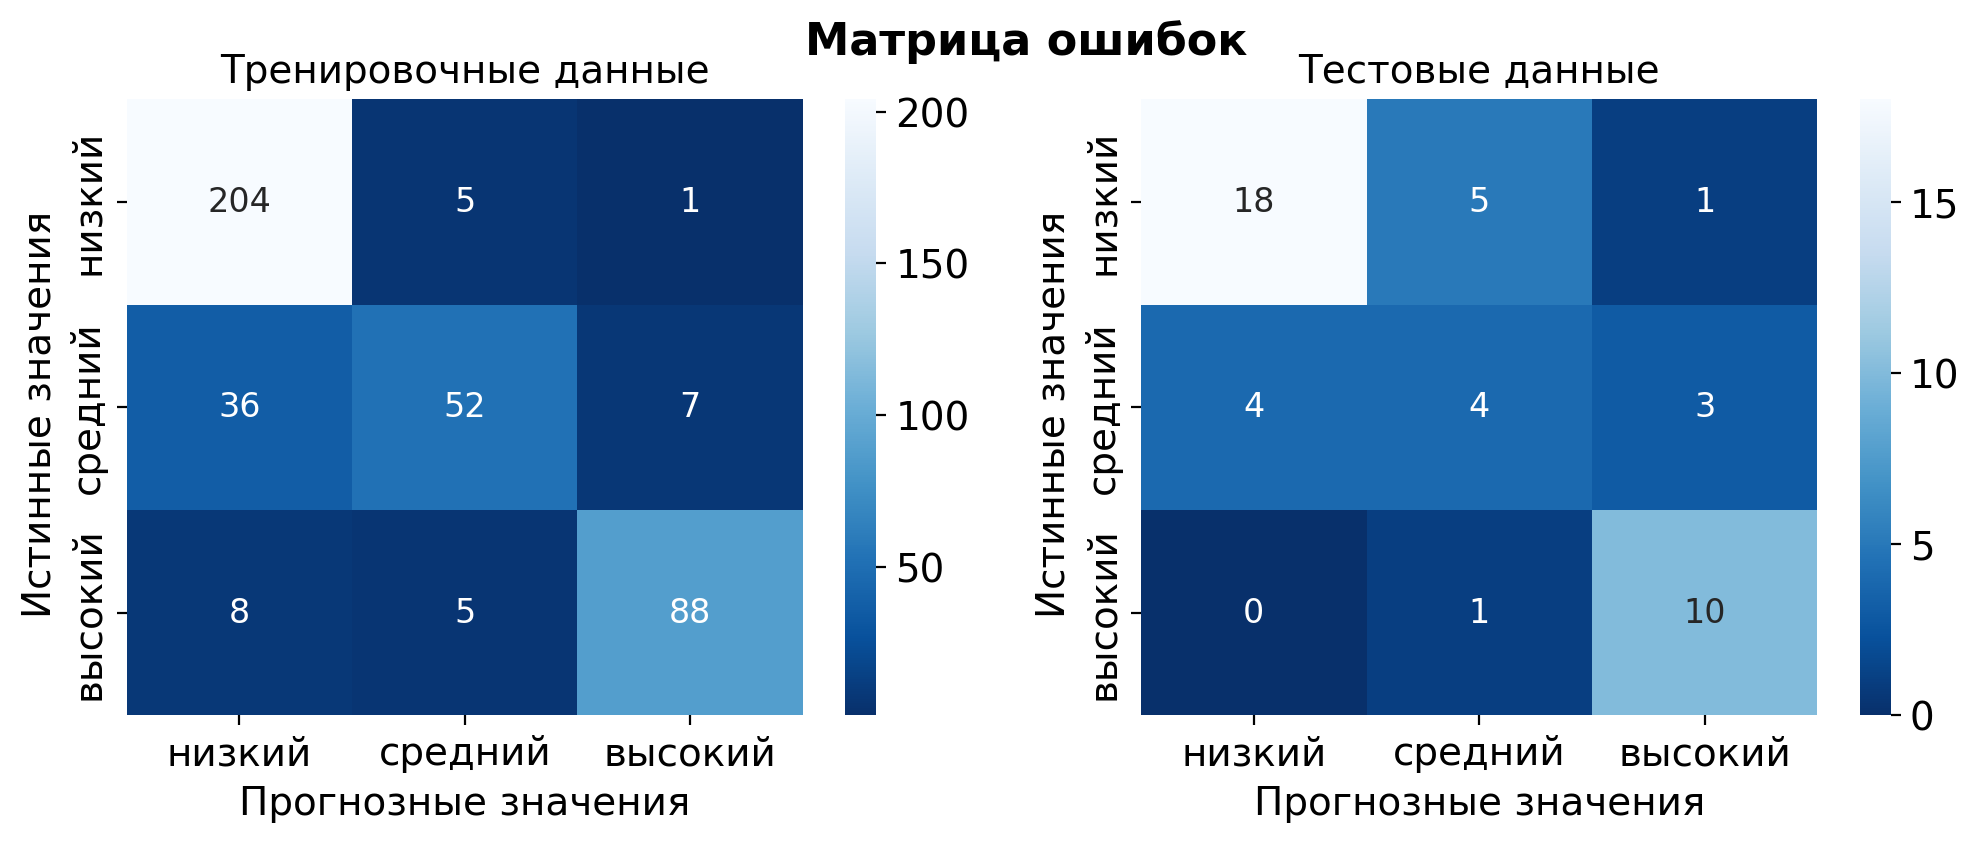

In [ ]:
# расчет матрицы ошибок
cm_train = confusion_matrix(y_train, model_xgbst.predict(X_train))
cm_test = confusion_matrix(y_test, y_test_pred)

# визуализация матрицы ошибок с помощью тепловой карты
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle('Матрица ошибок\n\n\n')

sns.heatmap(cm_train,
            annot=True, cmap='Blues_r',
            annot_kws={"size":12},
            fmt=".0f", ax=ax1)
ax1.set_title('Тренировочные данные');
ax1.set_xlabel('Прогнозные значения')
ax1.set_ylabel('Истинные значения ')
ax1.xaxis.set_ticklabels(['низкий', 'средний', 'высокий'])
ax1.yaxis.set_ticklabels(['низкий', 'средний', 'высокий'])

sns.heatmap(cm_test,
            annot=True, cmap='Blues_r',
            annot_kws={"size":12},
            fmt=".0f", ax=ax2)
ax2.set_title('Тестовые данные');
ax2.set_xlabel('Прогнозные значения')
ax2.set_ylabel('Истинные значения ')
ax2.xaxis.set_ticklabels(['низкий', 'средний', 'высокий'])
ax2.yaxis.set_ticklabels(['низкий', 'средний', 'высокий'])

plt.show()

Матрица ошибок показала хороший результат: верно были предсказаны 344 случая (TP+TN) против 62 неверных (FP+FN) на обучающей выборке, и 32 верных на тестовой против 14 неверных. Таким образом, модель достаточно хорошо позволяет выявить пациентов из группы риска.

## Вывод

В ходе данного проекта была построена модель МО для выявления беременных с рисками для здоровья.

Перед проведением анализа и моделирования была сделана <u>предобработка данных</u>, в ходе которой были выявлены следующие моменты и проведены следующие действия:
- Названия столбцов приведены к "змеиному" регистру.
- Аномальное значение ЧСС равное 7 уд/мин было рассмотрено как опечатка и умножено на 10, для приведения в нормальному.
- Были обнаружены 574 строчки с явными дубликатами. Они были удалены.
- Неявных дубликатов нет.

На этапе <u>исследовательского анализа данных</u>:
- В данных присутствует дисбаланс классов: данных по пациентам с низким уровнем риска в 2 раза больше (51.8% всех данных или 234 человека), чем пациентов со средним и высоким уровнем.
- Пациентов с высоким риском незначительно больше (на 1.3% или 6 человек), чем пациентов со средним уровнем риска.
- Признаки, позволяющие хорошо разграничить пациентам по трём группам риска: `age`, `bs`.
- Признаки, позволяющие хорошо выявить пациентов с высоким уровнем риска, но плохо разграничивающим низкий и средний уровень: `systolic_bp`, `diastolic_bp`, `heart_rate`.
- Признак, плохо разграничивающий пациентов по группам риска: `body_temp`.

В ходе <u>корреляционного анализа данных</u> были расчитана матрица корреляции коэффициентов Фи. Было выявлено, что мультиколлинеарность между признаками отсутствует.

На этапе <u>обучения модели</u> было построено 4 модели: LogisticRegression, KNeighborsClassifier, RandomForestClassifier, XGBClassifier. Для обучения использовались 6 входных признаков: 'age', 'systolic_bp', 'diastolic_bp', 'bs', 'body_temp', 'heart_rate'.

По результатам кросс-валидации лучшей оказалась модель XGBClassifier с параметрами {learning_rate=0.05, max_depth=5, n_estimators=100, random_state=10, StandardScaler()}. Ее метрика ROC-AUC на кросс-валидации равна 0.773. Метрика ROC-AUC на тестовых данных равна 0.848.

<u>Матрица ошибок</u> показала хороший результат: верно были предсказаны 344 случая (TP+TN) против 62 неверных (FP+FN) на обучающей выборке, и 32 верных на тестовой против 14 неверных. Таким образом, модель достаточно хорошо позволяет выявить пациентов из группы риска.

<u>Рекомендации:</u>
1. Можно протестировать вариант сведения данной задачи к бинарной классификации, т.е. разделения всех беременных на тех у кого есть риск и на тех у кого он низок, т.е объединения классов "средний риск" и "высокий риск". Таким образом, получится избежать дисбаланса классов и более точно выявить пациентов в группе риска.